In [1]:
import folium
import ruptures as rpt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic
import geoviews as gv
from IPython.display import display
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import plotly.express as px
import matplotlib.pyplot as plt
from holoviews import opts, dim

import warnings
warnings.filterwarnings('ignore')

opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':100, 'frame_width':100, 'cmap':'Viridis', 'colorbar':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))
kwargs = {**hvplot_defaults, 'line_width':4}

mpd.show_versions()


MovingPandas 0.20.0

SYSTEM INFO
-----------
python     : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
executable : C:\Users\bluer\anaconda3\python.exe
machine    : Windows-11-10.0.26100-SP0

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.9.1
GDAL data dir: C:\Users\bluer\anaconda3\Lib\site-packages\fiona\gdal_data
PROJ       : 9.4.1
PROJ data dir: C:\Users\bluer\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 1.0.1
pandas     : 2.2.2
fiona      : 1.10.1
numpy      : 1.26.4
shapely    : 2.0.6
pyproj     : 3.7.0
matplotlib : 3.9.2
mapclassify: 2.8.1
geopy      : 2.4.1
holoviews  : 1.19.1
hvplot     : 0.11.0
geoviews   : 1.14.0
stonesoup  : 1.5


In [2]:
data1 = gpd.read_file(r'C:\Users\bluer\Dropbox\Git-hub\Data\aisdk-2023-11-02(cargo_sample_narrow_path_for_paper).gpkg')
data = data1.copy()
Difference = pd.read_csv(r'C:\Users\bluer\Dropbox\Git-hub\Engine_info\Difference.csv')
Propulsion = pd.read_csv(r'C:\Users\bluer\Dropbox\Git-hub\Engine_info\Propulsion.csv')
Auxiliary = pd.read_csv(r'C:\Users\bluer\Dropbox\Git-hub\Engine_info\Auxiliary.csv')
Boiler = pd.read_csv(r'C:\Users\bluer\Dropbox\Git-hub\Engine_info\Boiler.csv')

In [3]:
Ship_spec = pd.read_csv(r'C:\Users\bluer\Dropbox\Git-hub\Engine_info\Ship_spec(11-02-Cargo__narrow_path_for_paper).csv', encoding='cp1252')

In [4]:
Ship_spec2 = pd.read_csv(r'C:\Users\bluer\Dropbox\Git-hub\Engine_info\Ship_spec(11-02-Cargo__narrow_path_for_paper)_marinetraffic.csv', encoding='cp1252')

# Input ship's Technical Specifications Information

In [5]:
def determine_subtype(row):
    ship_type = row['Ship Type']
    size = row['Size']

    # Bulk Carrier
    if ship_type == 'Bulk Carrier':
        if size <= 9999:
            return 'Small'
        elif size <= 34999:
            return 'Handysize'
        elif size <= 59999:
            return 'Handymax'
        elif size <= 99999:
            return 'Panamax'
        elif size <= 199999:
            return 'Capesize'
        else:
            return 'Capesize Largest'

    # Chemical Tanker
    elif ship_type == 'Chemical Tanker':
        if size <= 4999:
            return 'Smallest'
        elif size <= 9999:
            return 'Small'
        elif size <= 19999:
            return 'Handysize'
        else:
            return 'Handymax'

    # Container Ship
    elif ship_type == 'Container Ship':
        if size <= 999:
            return '1,000 TEU'
        elif size <= 1999:
            return '2,000 TEU'
        elif size <= 2999:
            return '3,000 TEU'
        elif size <= 4999:
            return '5,000 TEU'
        elif size <= 7999:
            return '8,000 TEU'
        elif size <= 11999:
            return '12,000 TEU'
        elif size <= 14499:
            return '14,500 TEU'
        else:
            return 'Largest'

    # Cruise
    elif ship_type == 'Cruise':
        if size <= 1999:
            return '2,000 Ton'
        elif size <= 9999:
            return '10,000 Ton'
        elif size <= 59999:
            return '60,000 Ton'
        elif size <= 99999:
            return '100,000 Ton'
        else:
            return 'Largest'

    # Ferry/Passenger (C3)
    elif ship_type == 'Ferry/Passenger (C3)':
        if size <= 1999:
            return '2,000 Ton'
        else:
            return 'Largest'

    # Ferry/Roll-on/Passenger (C3)
    elif ship_type == 'Ferry/Roll-on/Passenger (C3)':
        if size <= 1999:
            return '2,000 Ton'
        else:
            return 'Largest'

    # Fishing (C3)
    elif ship_type == 'Fishing (C3)':
        return 'All C3 Fishing'

    # General Cargo
    elif ship_type == 'General Cargo':
        if size <= 4999:
            return '5,000 DWT'
        elif size <= 9999:
            return '10,000 DWT'
        else:
            return 'Largest'

    # Liquified Gas Tanker
    elif ship_type == 'Liquified Gas Tanker':
        if size <= 49999:
            return '50,000 DWT'
        elif size <= 99999:
            return '100,000 DWT'
        elif size <= 199999:
            return '200,000 DWT'
        else:
            return 'Largest'

    # Miscellaneous (C3)
    elif ship_type == 'Miscellaneous (C3)':
        return 'All C3 Miscellaneous'

    # Offshore Support/Drillship
    elif ship_type == 'Offshore Support/Drillship':
        return 'All Offshore Support/Drillship'

    # Oil Tanker
    elif ship_type == 'Oil Tanker':
        if size <= 4999:
            return 'Smallest'
        elif size <= 9999:
            return 'Small'
        elif size <= 19999:
            return 'Handysize'
        elif size <= 59999:
            return 'Handymax'
        elif size <= 79999:
            return 'Panamax'
        elif size <= 119999:
            return 'Aframax'
        elif size <= 199999:
            return 'Suezmax'
        else:
            return 'VLCC'

    # Other Service
    elif ship_type == 'Other Service':
        return 'All Other Service'

    # Other Tanker
    elif ship_type == 'Other Tanker':
        return 'All Other Tanker'

    # Reefer
    elif ship_type == 'Reefer':
        return 'All Reefer'

    # RORO
    elif ship_type == 'RORO':
        if size <= 4999:
            return '5,000 Ton'
        else:
            return 'Largest'

    # Vehicle Carrier
    elif ship_type == 'Vehicle Carrier':
        if size <= 3999:
            return '4,000 Vehicles'
        else:
            return 'Largest'

    # Yacht (C2/C3)
    elif ship_type == 'Yacht (C2/C3)':
        return 'C2/C3 Yacht'

    # If 'Subtype' is not defined, return 'Undefined'
    return 'Undefined'

# Add a new 'Subtype' column
Ship_spec['Subtype'] = Ship_spec.apply(determine_subtype, axis=1)

# Remove data where 'Subtype' is 'Undefined'
Ship_spec = Ship_spec[Ship_spec['Subtype'] != 'Undefined']
Ship_spec = Ship_spec[Ship_spec['Ship Type'] != 'Vehicle Carrier']
Ship_spec = Ship_spec[Ship_spec['Ship Type'] != 'None']
Ship_spec = Ship_spec[Ship_spec['Ship Type'] != 'Cement Carrier']

# Set the index for Propulsion, Auxiliary, and Boiler dataframes (using 'Ship Type' and 'Subtype')
Propulsion.set_index(['Ship Type', 'Subtype'], inplace=True)
Auxiliary.set_index(['Ship Type', 'Subtype'], inplace=True)
Boiler.set_index(['Ship Type', 'Subtype'], inplace=True)

# Step 1: Merge required columns from the Propulsion dataframe into Ship_spec
propulsion_columns = ['Engine Category', 'Engine Type', 'Propulsion Power (kW)', 'Max Speed(kn)', 'Max Draft (m)']
Ship_spec_with_Propulsion = pd.merge(Ship_spec, Propulsion[propulsion_columns], left_on=['Ship Type', 'Subtype'], right_index=True, how='left')
Ship_spec_with_Propulsion.rename(columns={'Propulsion Power (kW)': 'Installed Propulsion Power (kW)'}, inplace=True)

# Step 2: Merge required columns from the Auxiliary dataframe into Ship_spec
auxiliary_columns = ['Transit (kW)', 'Maneuvering (kW)', 'Hotelling (kW)', 'Anchorage (kW)']
auxiliary_renamed_columns = ['Auxiliary Power - Transit (kW)', 'Auxiliary Power - Maneuvering (kW)', 'Auxiliary Power - Hotelling (kW)', 'Auxiliary Power - Anchorage (kW)']
Ship_spec_with_Auxiliary = pd.merge(Ship_spec_with_Propulsion, Auxiliary[auxiliary_columns], left_on=['Ship Type', 'Subtype'], right_index=True, how='left')
Ship_spec_with_Auxiliary.rename(columns=dict(zip(auxiliary_columns, auxiliary_renamed_columns)), inplace=True)

# Step 3: Merge required columns from the Boiler dataframe into Ship_spec
boiler_columns = ['Transit (kW)', 'Maneuvering (kW)', 'Hotelling (kW)', 'Anchorage (kW)']
boiler_renamed_columns = ['Boiler Power - Transit (kW)', 'Boiler Power - Maneuvering (kW)', 'Boiler Power - Hotelling (kW)', 'Boiler Power - Anchorage (kW)']
final_dataframe = pd.merge(Ship_spec_with_Auxiliary, Boiler[boiler_columns], left_on=['Ship Type', 'Subtype'], right_index=True, how='left')
final_dataframe.rename(columns=dict(zip(boiler_columns, boiler_renamed_columns)), inplace=True)

In [6]:
# Merge dataframes
merged_df = final_dataframe.merge(Ship_spec2, on='MMSI', how='left', suffixes=('', '_new'))

In [7]:
# Replace with new column values; if no value exists, use the existing value
merged_df['Installed Propulsion Power (kW)'] = merged_df['Installed Propulsion Power (kW)_new'].combine_first(merged_df['Installed Propulsion Power (kW)'])
merged_df['Max Speed(kn)'] = merged_df['Max Speed(kn)_new'].combine_first(merged_df['Max Speed(kn)'])

In [8]:
# Remove unnecessary columns
final_dataframe = merged_df.drop(columns=['Installed Propulsion Power (kW)_new', 'Max Speed(kn)_new'])

## Extracting Specific MMSI and Generating Trajectories

In [9]:
# List of MMSI to extract
mmsi_list = [538010605, 538004785]

data = data[data['MMSI'].isin(mmsi_list)]

In [10]:
geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
data = gpd.GeoDataFrame(data, geometry=geometry)
data['time'] = pd.to_datetime(data['# Timestamp'], format='%d/%m/%Y %H:%M:%S')
data = data.set_index('time')
collection = mpd.TrajectoryCollection(data, 'MMSI', min_length=5000)
collection

TrajectoryCollection with 2 trajectories

# Extract Trajectory Based on the Desired Area

In [11]:
area_of_interest = Polygon([(12.1, 56.3),(13, 56.3),(13, 55.4),(12.1, 55.4)])

In [12]:
clipped = collection.clip(area_of_interest)
data_clip = clipped.to_point_gdf()
# Splitting the MMSI column and keeping only the first part
data_clip['MMSI'] = data_clip['MMSI'].str.split('_').str[0]
data_clip['time'] = pd.to_datetime(data_clip['# Timestamp'], format='%d/%m/%Y %H:%M:%S')
data_clip = data_clip.set_index('time')
collection_1 = mpd.TrajectoryCollection(data_clip, 'MMSI')
collection_1

TrajectoryCollection with 2 trajectories

## Dock Area Diagram

In [13]:
area_of_wharf = Polygon([(10.534573790098127, 57.43062274232353), 
(10.535656410568714,57.43396395858403), 
(10.540852989952473, 57.44041242039378), 
(10.547493063609497, 57.44425764881965), 
(10.564104322471637, 57.43403261869249),   
(10.56407662864322, 57.427),   
(10.541358212948117, 57.429651401271464), 
(10.534573790098127, 57.43062274232353)])

# Preprocess and Adjust Data Range while Preserving Travel Distance

In [14]:
cleaned = collection_1.copy()
cleaned = mpd.OutlierCleaner(cleaned).clean(alpha=2)
smoothed0 = mpd.KalmanSmootherCV(cleaned).smooth(process_noise_std=0.5, measurement_noise_std=1)

for trajectory in smoothed0.trajectories:
    trajectory.add_distance(overwrite=True, name="distance (m)", units="m")

In [15]:
smoothed1 = smoothed0.to_point_gdf()
smoothed1['Cumulative Distance (m)'] = smoothed1['distance (m)'].cumsum()
smoothed1['MMSI'] = smoothed1['MMSI'].astype(int)

smoothed1 = mpd.TrajectoryCollection(smoothed1, 'MMSI') 
smoothed1 = mpd.MinTimeDeltaGeneralizer(smoothed1).generalize(tolerance=timedelta(minutes=1))

In [16]:
for trajectory in smoothed1.trajectories:
    trajectory.add_speed(overwrite=True, name="speed (knots)", units=("nm", "h"))
    trajectory.add_timedelta(overwrite=True)
    trajectory.add_distance(overwrite=True, name="distance (m)", units="m")

smoothed2 = smoothed1.to_point_gdf()

smoothed2['distance (m)'] = smoothed2['Cumulative Distance (m)'].diff().fillna(0)
smoothed2['seconds'] = smoothed2['timedelta'].dt.total_seconds()
smoothed2['speed (knots)_new'] = (smoothed2['distance (m)'] / smoothed2['seconds']) * 1.94384
smoothed2 = smoothed2.drop(columns=['seconds'])

In [17]:
if 'speed (knots)' in smoothed2.columns:
    smoothed2 = smoothed2.drop(columns=['speed (knots)'])
    smoothed2 = smoothed2.rename(columns={'speed (knots)_new': 'speed (knots)'})

In [18]:
# Process cases where the speed (knots) value of the first data point is NaN for each MMSI
def fill_first_nan(group):
    # Check if the first data point is NaN
    if pd.isna(group.iloc[0]['speed (knots)']):
        # Fill the first value with the second data point's value
        group.iloc[0, group.columns.get_loc('speed (knots)')] = group.iloc[1]['speed (knots)']
    return group

# Group by MMSI and process the first NaN value
smoothed2 = smoothed2.groupby('MMSI').apply(fill_first_nan).reset_index(drop=True)

In [19]:
smoothed2['time'] = pd.to_datetime(smoothed2['# Timestamp'], format='%d/%m/%Y %H:%M:%S')
smoothed2 = smoothed2.set_index('time')
smoothed = mpd.TrajectoryCollection(smoothed2, 'MMSI') 

In [20]:
# Visualization
kwargs = {**hvplot_defaults, 'line_width':2}
(collection_1.hvplot(title='Original Trajectory', **kwargs) + 
 cleaned.hvplot(title='Cleaned Trajectory', **kwargs) + 
 smoothed.hvplot(title='Cleaned & Smoothed Trajectory', **kwargs))

:Layout
   .Overlay.I   :Overlay
      .WMTS.I    :WMTS   [Longitude,Latitude]
      .Path.I    :Path   [Longitude,Latitude]
      .Path.II   :Path   [Longitude,Latitude]
      .Points.I  :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.II :Points   [Longitude,Latitude]   (triangle_angle)
   .Overlay.II  :Overlay
      .WMTS.I    :WMTS   [Longitude,Latitude]
      .Path.I    :Path   [Longitude,Latitude]
      .Path.II   :Path   [Longitude,Latitude]
      .Points.I  :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.II :Points   [Longitude,Latitude]   (triangle_angle)
   .Overlay.III :Overlay
      .WMTS.I    :WMTS   [Longitude,Latitude]
      .Path.I    :Path   [Longitude,Latitude]
      .Path.II   :Path   [Longitude,Latitude]
      .Points.I  :Points   [Longitude,Latitude]   (triangle_angle)
      .Points.II :Points   [Longitude,Latitude]   (triangle_angle)

# Distinguish between Anchoring and Cruising

## Extract Activity Data Near the Wharf (to differentiate between Maneuvering and Hotelling)

In [21]:
detector = mpd.TrajectoryStopDetector(smoothed)

clipped = smoothed.clip(area_of_wharf)

# Check if the trajectory collection is empty (i.e., no trajectories exist).
if len(clipped.trajectories) == 0:
    # Create an empty GeoDataFrame while maintaining the original DataFrame structure.
    Wharf_df = gpd.GeoDataFrame(columns=['geometry', 'MMSI', '# Timestamp'])  
else:
    Wharf_df = clipped.to_point_gdf()
    def remove_datetime_from_mmsi(mmsi_str):
        # Split the string based on the '_' character and return only the first part (the actual MMSI).
        return mmsi_str.split('_')[0]

    # Proceed with 'MMSI' modification only if there is data.
    if not Wharf_df.empty:
        # Apply the function to modify the 'MMSI' column.
        Wharf_df['MMSI'] = Wharf_df['MMSI'].apply(remove_datetime_from_mmsi)
        Wharf_df['MMSI'] = Wharf_df['MMSI'].astype('int64')

## Identify Stop Points and Add Them to the GeoDataFrame

In [22]:
# If a vessel moves less than approximately 400m in 4000 seconds, it is considered as stop point
stop_time_ranges = detector.get_stop_time_ranges(min_duration=timedelta(seconds=4000), max_diameter=400)
for x in stop_time_ranges: 
    print(x)
    
# Convert all trajectories in the TrajectoryCollection to a DataFrame
all_trajectories = []
for traj in smoothed:
    # Retrieve the DataFrame of each trajectory
    traj_df = traj.df  
    traj_df['MMSI'] = traj.id  
    all_trajectories.append(traj_df)

# Combine individual DataFrames into a single large DataFrame.
complete_df = pd.concat(all_trajectories)

# Initialize the 'status' column as 'Transit'.
complete_df['status'] = 'Transit'

for traj in stop_time_ranges:
    traj_id = traj.traj_id 
    start_time = traj.t_0  # 't_0' represents the start time
    end_time = traj.t_n  # 't_n' represents the end time

    # Use this information to update the 'status' column
    mask = (complete_df['MMSI'] == traj_id) & (complete_df.index >= start_time) & (complete_df.index <= end_time)
    complete_df.loc[mask, 'status'] = 'Anchorage'

## Classify Operating Mode

In [23]:
%%time
# Define a function to create the 'Operating Mode' column
def determine_operating_mode(row):
    # Retrieve the 'MMSI' and 'Timestamp' values of the current row
    current_mmsi = row['MMSI']
    current_timestamp = row['# Timestamp']

    # Check if there is a row in 'Wharf_df' with the same 'MMSI' and 'Timestamp' as the current row
    matched_row = Wharf_df[(Wharf_df['MMSI'] == current_mmsi) & (Wharf_df['# Timestamp'] == current_timestamp)]

    # Determine 'Operating Mode' based on the 'status' value
    if row['status'] == 'Transit':
        # If 'matched_row' is not empty (i.e., a matching row exists in 'Wharf_df'), return 'Maneuvering'
        return 'Maneuvering' if not matched_row.empty else 'Transit'
    elif row['status'] == 'Anchorage':
        # Similarly, if 'matched_row' is not empty, return 'Hotelling'
        return 'Hotelling' if not matched_row.empty else 'Anchorage'

# Apply the 'determine_operating_mode' function to each row in 'complete_df'
complete_df['Operating Mode'] = complete_df.apply(determine_operating_mode, axis=1)

CPU times: total: 422 ms
Wall time: 396 ms


In [24]:
complete_df['Operating Mode'] = complete_df['Operating Mode'].replace('Anchorage', 'Hotelling')

In [25]:
complete_df['Operating Mode'].unique()

array(['Transit'], dtype=object)

# Emission Calculation (Based on AIS data)

## Calculate Load Factor (LF)

In [26]:
merged_df = pd.merge(complete_df, final_dataframe, on='MMSI', how='left')
new_df = merged_df.copy()

In [27]:
global_sea_margin = None  # Variable to store the global Sea Margin value

def get_sea_margin(mmsi):
    """
    Prompt the user to input the Sea Margin (SM) value for each MMSI.
    """
    global global_sea_margin # Declare to use the global variable

    # If the global Sea Margin value is already set, use it
    if global_sea_margin is not None:
        return global_sea_margin

    print(f"Select the Sea Margin (SM) for MMSI {mmsi}:")
    print("1: 1.10 for coastal operations")
    print("2: 1.15 for at-sea operations (unitless)")
    print("3: Apply 1.10 to all MMSIs")

    selection = input("Select (1, 2, or 3): ")

    if selection == "1":
        return 1.10
    elif selection == "2":
        return 1.15
    elif selection == "3":
        global_sea_margin = 1.10  # Set the global Sea Margin value to apply to all MMSIs
        return global_sea_margin
    else:
        print("Invalid selection. Please try again.")
        return get_sea_margin(mmsi)


def calculate_load_factor(row, sea_margins):
    """
    alculate the Load Factor (LF) for a given row.
    """
    sea_margin = sea_margins.get(row['MMSI'])
    if row['Max Speed(kn)'] == 0: # Prevent division by zero if speed is 0
        return 0
    else:
        return sea_margin * ((row['speed (knots)'] / row['Max Speed(kn)']) ** 3)


# Extract unique MMSIs from new_df
unique_mmsis = new_df['MMSI'].unique()

# Store the Sea Margin value for each MMSI
sea_margins = {}
for mmsi in unique_mmsis:
    sea_margins[mmsi] = get_sea_margin(mmsi)

# Calculate 'Load Factor' and add it as a new column
new_df['Load Factor(LF)'] = new_df.apply(lambda row: calculate_load_factor(row, sea_margins), axis=1)

Select the Sea Margin (SM) for MMSI 538004785:
1: 1.10 for coastal operations
2: 1.15 for at-sea operations (unitless)
3: Apply 1.10 to all MMSIs


Select (1, 2, or 3):  3


## Convert Timedelta to Hours

In [28]:
new_df['timedelta_hours'] = new_df['timedelta'].dt.total_seconds() / 3600

# Calculate Propulsion Engine Emissions

In [29]:
def calculate_additional_power(row):
    mode = row['Operating Mode']
    
    # Perform calculations for Transit or Maneuvering mode
    if mode in ['Transit', 'Maneuvering']:
        result = row['Installed Propulsion Power (kW)'] * row['Load Factor(LF)'] * row['timedelta_hours']
    else:
        # Return 0 for Hotelling or Anchorage mode
        result = 0
    
    return result

# Add a new column 'Propulsion Power_Processing' to the previously created new_df dataframe
new_df['Propulsion Power_Processing'] = new_df.apply(lambda row: calculate_additional_power(row), axis=1)

def calculate_auxiliary_power(row):
    mode = row['Operating Mode']
    hours = row['timedelta_hours']
    power = 0

    if mode == 'Transit':
        power = row['Auxiliary Power - Transit (kW)']
    elif mode == 'Anchorage':
        power = row['Auxiliary Power - Anchorage (kW)']
    elif mode == 'Hotelling':
        power = row['Auxiliary Power - Hotelling (kW)']
    elif mode == 'Maneuvering':
        power = row['Auxiliary Power - Maneuvering (kW)']

    return power * hours

new_df['Auxiliary Power_Processing'] = new_df.apply(lambda row: calculate_auxiliary_power(row), axis=1)

def calculate_boiler_power(row):
    mode = row['Operating Mode']
    hours = row['timedelta_hours']
    power = 0

    if mode == 'Transit':
        power = row['Boiler Power - Transit (kW)']
    elif mode == 'Anchorage':
        power = row['Boiler Power - Anchorage (kW)']
    elif mode == 'Hotelling':
        power = row['Boiler Power - Hotelling (kW)']
    elif mode == 'Maneuvering':
        power = row['Boiler Power - Maneuvering (kW)']

    return power * hours

new_df['Boiler Power_Processing'] = new_df.apply(lambda row: calculate_boiler_power(row), axis=1)

In [30]:
LLAF_By_LF = {
    'Load Factor': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'NOx': [4.63, 2.92, 2.21, 1.83, 1.60, 1.45, 1.35, 1.27, 1.22, 1.17, 1.14, 1.11, 1.08, 1.06, 1.05, 1.03, 1.02, 1.01, 1.00],
    'HC': [21.18, 11.68, 7.71, 5.61, 4.35, 3.52, 2.95, 2.52, 2.20, 1.96, 1.76, 1.60, 1.47, 1.36, 1.26, 1.18, 1.11, 1.05, 1.00],
    'CO': [9.68, 6.46, 4.86, 3.89, 3.25, 2.79, 2.45, 2.18, 1.96, 1.79, 1.64, 1.52, 1.41, 1.32, 1.24, 1.17, 1.11, 1.05, 1.00],
    'PM': [7.29, 4.33, 3.09, 2.44, 2.04, 1.79, 1.61, 1.48, 1.38, 1.30, 1.24, 1.19, 1.15, 1.11, 1.08, 1.06, 1.04, 1.02, 1.00],
    'CO2': [3.28, 2.44, 2.01, 1.76, 1.59, 1.47, 1.38, 1.31, 1.25, 1.21, 1.17, 1.14, 1.11, 1.08, 1.06, 1.04, 1.03, 1.01, 1.00],
    'SO2': [9.54, 6.38, 4.79, 3.85, 3.21, 2.76, 2.42, 2.16, 1.95, 1.78, 1.63, 1.51, 1.41, 1.32, 1.24, 1.17, 1.11, 1.05, 1.00],
}
LLAF_By_LF = pd.DataFrame(LLAF_By_LF)
LLAF_By_LF.set_index('Load Factor', inplace=True)

new_df1 = new_df.copy()

# Check if there are any NaN values in the 'Load Factor(LF)' column
## If the result is False, it is safe to proceed to the next code
nan_in_load_factor = new_df1['Load Factor(LF)'].isna().any()
nan_in_load_factor

False

## LLAF Calculation

In [31]:
# Add columns for all pollutants
pollutant_columns = list(LLAF_By_LF.columns) 

def calculate_llaf(row, pollutant):
    if row['Operating Mode'] in ['Anchorage', 'Hotelling']:
        return 0
    else:
        lf = row['Load Factor(LF)'] * 100
        lf_rounded = int(lf) 
        if lf_rounded >= 20:
            return 1
        elif lf_rounded <= 2:
            return LLAF_By_LF.loc[2, pollutant] if 2 in LLAF_By_LF.index else None
        else:
            if lf_rounded in LLAF_By_LF.index:
                return LLAF_By_LF.loc[lf_rounded, pollutant]
            else:
                return None 

# Add LLAF columns for each pollutant
for pollutant in pollutant_columns:
    llaf_column_name = f'LLAF_{pollutant}'   # Set column name
    new_df1[llaf_column_name] = new_df1.apply(lambda row: calculate_llaf(row, pollutant), axis=1)
    
# Function to perform multiplication and create new columns
def calculate_and_create_columns(df, propulsion_column, factors):
    for factor in factors:
        new_column_name = f"{factor}_Processed" # Generate new column name
        df[new_column_name] = df[propulsion_column] * df[factor]   # Perform multiplication and assign values to the new column
    return df

# List of column names that need to be multiplied by "Propulsion Power_Processing"
factors_to_multiply = ['LLAF_HC', 'LLAF_CO', 'LLAF_NOx', 'LLAF_PM', 'LLAF_CO2', 'LLAF_SO2']

# Use the function to create new columns
new_df1 = calculate_and_create_columns(new_df1, 'Propulsion Power_Processing', factors_to_multiply)

## Total CO2 Emission Calculation

In [32]:
def calculate_factors(engine_type):
    if engine_type == 'SSD':
        return 185 * 3.206, 217 * 3.206, 300 * 3.206
    elif engine_type == 'MSD':
        return 205 * 3.206, 217 * 3.206, 300 * 3.206
    else:
        return None, None, None 

# Function to calculate and print the factors for the first data entry of each MMSI group
def print_first_mmsi_factors(df):
    # Group by MMSI and apply the function only to the first data entry
    grouped = df.groupby('MMSI').first().reset_index()
    for _, row in grouped.iterrows():
        factors = calculate_factors(row['Engine Type'])
        print(f"MMSI: {row['MMSI']}, "
              f"Propulsion_Factor: {factors[0]}, "
              f"Auxiliary_Factor: {factors[1]}, "
              f"Boiler_Factor: {factors[2]}")
        
new_df1['Operating Mode'].unique()

array(['Transit'], dtype=object)

In [33]:
# Function to calculate emission factors and estimate emissions per MMSI group
def calculate_emissions(df):
    results_list = []
    
    # Group by MMSI and apply the function only to the first data entry
    grouped = df.groupby('MMSI').first().reset_index()
    for _, row in grouped.iterrows():
        factors = calculate_factors(row['Engine Type'])  
        propulsion_factor, auxiliary_factor, boiler_factor = factors

        # Select all data for the given MMSI
        ship_data = df[df['MMSI'] == row['MMSI']]

        # Calculate emissions
        propulsion_emission = ship_data['LLAF_CO2_Processed'].sum() * propulsion_factor
        auxiliary_emission = ship_data['Auxiliary Power_Processing'].sum() * auxiliary_factor
        boiler_emission = ship_data['Boiler Power_Processing'].sum() * boiler_factor
        total_emission = propulsion_emission + auxiliary_emission + boiler_emission

        # Create result dictionary and add it to the results list
        result = {
            'MMSI': row['MMSI'],
            'Ship Type': row['Ship Type'],
            'Subtype': row['Subtype'],
            'Pollutant': 'CO2',
            'Propulsion_Emission(kg)': propulsion_emission / 1000,  # Convert from g to kg
            'Auxiliary_Emission(kg)': auxiliary_emission / 1000, 
            'Boiler_Emission(kg)': boiler_emission / 1000, 
            'Total_Emission(kg)': total_emission / 1000,  
        }

        # Group by operating mode to calculate total hours and distance
        mode_time_distance = ship_data.groupby('Operating Mode')[['timedelta_hours', 'distance (m)']].sum()
        
        # Add hours and distance data for each operating mode
        for mode in ['Maneuvering', 'Hotelling', 'Transit', 'Anchorage']:
            result[f"{mode}_Hours"] = mode_time_distance.loc[mode, 'timedelta_hours'] if mode in mode_time_distance.index else 0
            result[f"{mode}_Distance_km"] = mode_time_distance.loc[mode, 'distance (m)'] / 1000 if mode in mode_time_distance.index else 0

        results_list.append(result)

    # Convert results list into a DataFrame
    results_df = pd.DataFrame(results_list)
    return results_df

# Function to calculate and apply propulsion, auxiliary, and boiler emission factors
def apply_emission_factors(row):
    factors = calculate_factors(row['Engine Type']) 
    row['Propulsion_Emission_Factor'] = row['LLAF_CO2_Processed'] * factors[0]
    row['Auxiliary_Emission_Factor'] = row['Auxiliary Power_Processing'] * factors[1]
    row['Boiler_Emission_Factor'] = row['Boiler Power_Processing'] * factors[2]
    return row

# Apply the function to new_df1 to add new columns
new_df1 = new_df1.apply(apply_emission_factors, axis=1)

# Call the modified function to store and display the results
results_df = calculate_emissions(new_df1)


# Calculate new columns
new_df1['timedelta_sec'] = new_df1['timedelta'].dt.total_seconds()
new_df1['Emission per sec'] = (new_df1['Propulsion_Emission_Factor'] + 
                               new_df1['Auxiliary_Emission_Factor'] + 
                               new_df1['Boiler_Emission_Factor']) / new_df1['timedelta_sec']

# Sum 'Maneuvering_Hours', 'Hotelling_Hours', 'Transit_Hours', and 'Anchorage_Hours' for each MMSI
results_df['Total_Hours'] = (
    results_df['Maneuvering_Hours'] +
    results_df['Hotelling_Hours'] +
    results_df['Transit_Hours'] +
    results_df['Anchorage_Hours'])

# Sum 'Maneuvering_Distance_km', 'Hotelling_Distance_km', 'Transit_Distance_km', and 'Anchorage_Distance_km' for each MMSI
results_df['Total_Distance_km'] = (
    results_df['Maneuvering_Distance_km'] +
    results_df['Hotelling_Distance_km'] +
    results_df['Transit_Distance_km'] +
    results_df['Anchorage_Distance_km'])

In [34]:
new_df1['Propulsion_Emission per sec'] = (new_df1['Propulsion_Emission_Factor']) / new_df1['timedelta_sec']

# Emission Calculation (Based on Average Speed)

In [35]:
# Define a function to calculate speed and convert from km/h to knots
def calculate_speed_knots(distance, hours):
    # If time is 0, set speed to 0
    if hours == 0:
        return 0
    else:
        speed_kmh = distance / hours  # Calculate speed in km/h
        speed_knots = speed_kmh * 0.539957  # Convert km/h to knots
        return speed_knots

# Calculate 'Maneuvering_Average_Speed' and add it as a new column (in knots)
results_df['Maneuvering_Average_Speed(knot)'] = results_df.apply(
    lambda row: calculate_speed_knots(row['Maneuvering_Distance_km'], row['Maneuvering_Hours']), axis=1)

# Calculate 'Transit_Average_Speed' and add it as a new column (in knots, assuming the column exists)
results_df['Transit_Average_Speed(knot)'] = results_df.apply(
    lambda row: calculate_speed_knots(row['Transit_Distance_km'], row['Transit_Hours']), axis=1)

# Select only the required columns for the new DataFrame
columns_to_keep = [
    'MMSI', 'Ship Type', 'Subtype', 'Pollutant', 
    'Maneuvering_Average_Speed(knot)', 'Transit_Average_Speed(knot)', 
    'Maneuvering_Hours', 'Hotelling_Hours', 
    'Transit_Hours', 'Anchorage_Hours'
]

results_df_average = results_df[columns_to_keep].copy() 

columns_to_merge = ['MMSI', 'Max Speed(kn)', 'Engine Type', 'Installed Propulsion Power (kW)', 
                    'Auxiliary Power - Transit (kW)', 'Auxiliary Power - Maneuvering (kW)',	'Auxiliary Power - Hotelling (kW)',	'Auxiliary Power - Anchorage (kW)',
                    'Boiler Power - Transit (kW)','Boiler Power - Maneuvering (kW)', 'Boiler Power - Hotelling (kW)', 'Boiler Power - Anchorage (kW)']

results_df_average['MMSI'] = results_df_average['MMSI'].astype(int)
final_dataframe['MMSI'] = final_dataframe['MMSI'].astype(int)

# Merge the two dataframes using 'MMSI' as the key, keeping only the selected columns
results_df_average = pd.merge(results_df_average, final_dataframe[columns_to_merge], on='MMSI', how='inner', sort=False)

In [36]:
def get_sea_margin(mmsi, global_selection=None):
    """
    Prompt the user to input the Sea Margin (SM) value for each MMSI.
    Select option 3 to apply a global value.
    """
    # If a global selection has already been made, use that value directly.
    if global_selection is not None:
        return global_selection

    print(f"Select the Sea Margin (SM) for MMSI {mmsi}:")
    print("1: 1.10 for coastal operations")
    print("2: 1.15 for at-sea operations (unitless)")
    print("3: Apply 1.10 to all MMSIs")

    selection = input("Select (1, 2, or 3): ")

    if selection == "1":
        return 1.10
    elif selection == "2":
        return 1.15
    elif selection == "3":
        return 1.10
    else:
        print("Invalid selection. Please try again.")
        return get_sea_margin(mmsi)

sea_margins = {}

global_selection = None

unique_mmsis = results_df_average['MMSI'].unique()
if len(unique_mmsis) > 0:
    global_selection = get_sea_margin(unique_mmsis[0])

for mmsi in unique_mmsis:
    sea_margins[mmsi] = get_sea_margin(mmsi, global_selection)

results_df_average['Sea Margin(SM)'] = results_df_average['MMSI'].map(sea_margins)

results_df_average['Maneuvering_SM_Result'] = 0.0
results_df_average['Transit_SM_Result'] = 0.0

for index, row in results_df_average.iterrows():
    if row['Maneuvering_Hours'] > 0:
        maneuvering_ratio = (row['Maneuvering_Average_Speed(knot)'] / row['Max Speed(kn)']) ** 3
        results_df_average.at[index, 'Maneuvering_SM_Result'] = maneuvering_ratio * row['Sea Margin(SM)']

    if row['Transit_Hours'] > 0:
        transit_ratio = (row['Transit_Average_Speed(knot)'] / row['Max Speed(kn)']) ** 3
        results_df_average.at[index, 'Transit_SM_Result'] = transit_ratio * row['Sea Margin(SM)']

Select the Sea Margin (SM) for MMSI 538004785:
1: 1.10 for coastal operations
2: 1.15 for at-sea operations (unitless)
3: Apply 1.10 to all MMSIs


Select (1, 2, or 3):  3


In [37]:
pollutants = ['NOx', 'HC', 'CO', 'PM', 'CO2', 'SO2']
for mode in ['Maneuvering', 'Transit']:
    for pollutant in pollutants:
        column_name = f'{mode}_{pollutant}_LLAF'
        results_df_average[column_name] = None  

for index, row in results_df_average.iterrows():
    for mode in ['Maneuvering', 'Transit']:
        factor = row[f'{mode}_SM_Result']

        factor_key = int(factor * 100)

        if factor_key >= 20:
            for pollutant in pollutants:
                column_name = f'{mode}_{pollutant}_LLAF'
                results_df_average.at[index, column_name] = 1
        else:
            if factor_key <= 2:
                factor_key = 2
            if factor_key in LLAF_By_LF.index:
                for pollutant in pollutants:
                    column_name = f'{mode}_{pollutant}_LLAF'
                    results_df_average.at[index, column_name] = LLAF_By_LF.at[factor_key, pollutant]

In [38]:
# Replace 'None' or 'NaN' values with 0.
results_df_average.fillna(0, inplace=True)

## CO2 Emission Calculation

In [39]:
new_df1['MMSI'] = new_df1['MMSI'].astype(int)

In [40]:
def calculate_factors(engine_type):
    if engine_type == 'SSD':
        return 185 * 3.206, 217 * 3.206, 300 * 3.206
    elif engine_type == 'MSD':
        return 205 * 3.206, 217 * 3.206, 300 * 3.206
    else:
        return None, None, None  
    
def calculate_first_mmsi_factors(df):
    factors_dict = {}
    grouped = df.groupby('MMSI').first().reset_index()
    for _, row in grouped.iterrows():
        factors = calculate_factors(row['Engine Type'])
        factors_dict[row['MMSI']] = {
            'propulsion': factors[0],
            'auxiliary': factors[1],
            'boiler': factors[2]
        }
    return factors_dict 

emission_factors = calculate_first_mmsi_factors(new_df1)
pollutant_dict = {1: 'NOx', 2: 'HC', 3: 'CO', 4: 'PM', 5: 'CO2', 6: 'SO2'}

pollutant_choice = 5 
pollutant = pollutant_dict[pollutant_choice]
def calculate_emissions(row, pollutant, emission_factors):
    mmsi = row['MMSI']
    ef = emission_factors[mmsi] 
    maneuvering_llaf = row[f'Maneuvering_{pollutant}_LLAF']
    transit_llaf = row[f'Transit_{pollutant}_LLAF']
    
    if maneuvering_llaf == 0:
        propulsion_maneuvering = (row['Maneuvering_SM_Result'] * row['Installed Propulsion Power (kW)'] *
                                  row['Maneuvering_Hours'] * ef['propulsion'])
    else:
        propulsion_maneuvering = (row['Maneuvering_SM_Result'] * row['Installed Propulsion Power (kW)'] *
                                  row['Maneuvering_Hours'] * ef['propulsion'] * maneuvering_llaf)
    
    if transit_llaf == 0:
        propulsion_transit = (row['Transit_SM_Result'] * row['Installed Propulsion Power (kW)'] *
                              row['Transit_Hours'] * ef['propulsion'])
    else:
        propulsion_transit = (row['Transit_SM_Result'] * row['Installed Propulsion Power (kW)'] *
                              row['Transit_Hours'] * ef['propulsion'] * transit_llaf)
    
    auxiliary_maneuvering = row['Auxiliary Power - Maneuvering (kW)'] * row['Maneuvering_Hours'] * ef['auxiliary']
    auxiliary_anchorage = row['Auxiliary Power - Anchorage (kW)'] * row['Anchorage_Hours'] * ef['auxiliary']
    auxiliary_hotelling = row['Auxiliary Power - Hotelling (kW)'] * row['Hotelling_Hours'] * ef['auxiliary']
    auxiliary_transit = row['Auxiliary Power - Transit (kW)'] * row['Transit_Hours'] * ef['auxiliary']
    
    boiler_maneuvering = row['Boiler Power - Maneuvering (kW)'] * row['Maneuvering_Hours'] * ef['boiler']
    boiler_anchorage = row['Boiler Power - Anchorage (kW)'] * row['Anchorage_Hours'] * ef['boiler']
    boiler_hotelling = row['Boiler Power - Hotelling (kW)'] * row['Hotelling_Hours'] * ef['boiler']
    

    total_propulsion = propulsion_maneuvering + propulsion_transit
    total_auxiliary = auxiliary_maneuvering + auxiliary_anchorage + auxiliary_hotelling + auxiliary_transit
    total_boiler = boiler_maneuvering + boiler_anchorage + boiler_hotelling

    total_propulsion_kg = total_propulsion / 1000  
    total_auxiliary_kg = total_auxiliary / 1000
    total_boiler_kg = total_boiler / 1000

    total_emissions_kg = total_propulsion_kg + total_auxiliary_kg + total_boiler_kg
    
    return pd.Series({
        'Propulsion_Emission(kg)': total_propulsion_kg,
        'Auxiliary_Emission(kg)': total_auxiliary_kg,
        'Boiler_Emission(kg)': total_boiler_kg,
        'Total_Emission(kg)': total_emissions_kg
    })

emissions_df = results_df_average.apply(lambda row: calculate_emissions(row, pollutant, emission_factors), axis=1)

results_df_average = pd.concat([results_df_average, emissions_df], axis=1)

results_df_average

,MMSI,Ship Type,Subtype,Pollutant,Maneuvering_Average_Speed(knot),Transit_Average_Speed(knot),Maneuvering_Hours,Hotelling_Hours,Transit_Hours,Anchorage_Hours,...,Transit_NOx_LLAF,Transit_HC_LLAF,Transit_CO_LLAF,Transit_PM_LLAF,Transit_CO2_LLAF,Transit_SO2_LLAF,Propulsion_Emission(kg),Auxiliary_Emission(kg),Boiler_Emission(kg),Total_Emission(kg)
0,538004785,Bulk Carrier,Handymax,CO2,0,10.751295,0,0,6.136111,0,...,1,1,1,1,1,1,16253.945118,1109.915241,0.0,17363.860359
1,538010605,Bulk Carrier,Handymax,CO2,0,9.186464,0,0,7.291667,0,...,1,1,1,1,1,1,9919.953965,1318.935042,0.0,11238.889007


# 배출량 비교(AIS 기반 vs 평균속도 기반)

In [41]:
results_df['MMSI'] = results_df['MMSI'].astype(int)

In [42]:
# First, merge the two dataframes based on 'MMSI', 'Ship Type', 'Subtype', and 'Pollutant'.
merged_df = pd.merge(results_df, results_df_average, on=['MMSI', 'Ship Type', 'Subtype', 'Pollutant'], how='inner')

# Select only the necessary columns from the merged dataframe.
selected_columns = [
    'MMSI', 'Ship Type', 'Subtype', 'Pollutant', 
    'Propulsion_Emission(kg)_x', 'Auxiliary_Emission(kg)_x', 'Boiler_Emission(kg)_x', 'Total_Emission(kg)_x',
    'Propulsion_Emission(kg)_y', 'Auxiliary_Emission(kg)_y', 'Boiler_Emission(kg)_y', 'Total_Emission(kg)_y'
]

final_df = merged_df[selected_columns]

rename_columns = {
    'Propulsion_Emission(kg)_x': 'Propulsion_Emission(kg)',
    'Auxiliary_Emission(kg)_x': 'Auxiliary_Emission(kg)',
    'Boiler_Emission(kg)_x': 'Boiler_Emission(kg)',
    'Total_Emission(kg)_x': 'Total_Emission(kg)',
    'Propulsion_Emission(kg)_y': 'Propulsion_Emission(kg)_average',
    'Auxiliary_Emission(kg)_y': 'Auxiliary_Emission(kg)_average',
    'Boiler_Emission(kg)_y': 'Boiler_Emission(kg)_average',
    'Total_Emission(kg)_y': 'Total_Emission(kg)_average'
}

# Rename the columns.
final_df = final_df.rename(columns=rename_columns)
final_df

,MMSI,Ship Type,Subtype,Pollutant,Propulsion_Emission(kg),Auxiliary_Emission(kg),Boiler_Emission(kg),Total_Emission(kg),Propulsion_Emission(kg)_average,Auxiliary_Emission(kg)_average,Boiler_Emission(kg)_average,Total_Emission(kg)_average
0,538004785,Bulk Carrier,Handymax,CO2,17212.320114,1109.915241,0.0,18322.235355,16253.945118,1109.915241,0.0,17363.860359
1,538010605,Bulk Carrier,Handymax,CO2,11559.961298,1318.935042,0.0,12878.896340,9919.953965,1318.935042,0.0,11238.889007


In [43]:
merged_df = pd.merge(final_df, results_df[['MMSI', 'Total_Hours', 'Total_Distance_km']], on='MMSI')

grouped = merged_df.groupby('MMSI')

for name, group in grouped:
    print(f"MMSI: {name}")

    total_hours = group['Total_Hours'].iloc[0]
    total_distance = group['Total_Distance_km'].iloc[0]

    print(f"Total Hours: {total_hours}")
    print(f"Total Distance: {total_distance} km")

    for index, row in group.iterrows():
        ship_type = row['Ship Type']
        subtype = row['Subtype']
        pollutant = row['Pollutant']
        total_emission = row['Total_Emission(kg)']
        avg_emission = row['Total_Emission(kg)_average']

        print(f"Ship Type: {ship_type}, Subtype: {subtype}")
        print(f"Pollutant: {pollutant}")
        print(f"Emission based on detailed speed variations: {total_emission} kg")
        print(f"Emission based on constant speed: {avg_emission} kg")

        # If avg_emission is a Series, use the first value.
        if isinstance(avg_emission, pd.Series):
            avg_emission = avg_emission.iloc[0]

        if avg_emission != 0:
            difference = total_emission - avg_emission
            percentage_difference = (difference / avg_emission) * 100

            if difference > 0:
                print(f"Emission based on detailed speed variations is {difference:.2f} kg ({percentage_difference:.2f}%) higher than the Emission based on constant speed.")
            elif difference < 0:
                print(f"Emission based on detailed speed variations is {-difference:.2f} kg ({-percentage_difference:.2f}%) lower than the Emission based on constant speed.")
            else:
                print("Emission based on detailed speed variations is equal to the average.")
        else:
            print("Note: Emission based on constant speed is zero, cannot calculate difference.")
        
        print("-" * 30)  # 구분선 출력

    print("=" * 30)  # MMSI 간 구분선 출력

MMSI: 538004785
Total Hours: 6.136111111111111
Total Distance: 122.17850580325941 km
Ship Type: Bulk Carrier, Subtype: Handymax
Pollutant: CO2
Emission based on detailed speed variations: 18322.23535498412 kg
Emission based on constant speed: 17363.860359074635 kg
Emission based on detailed speed variations is 958.37 kg (5.52%) higher than the Emission based on constant speed.
------------------------------
MMSI: 538010605
Total Hours: 7.291666666666667
Total Distance: 124.05549007986504 km
Ship Type: Bulk Carrier, Subtype: Handymax
Pollutant: CO2
Emission based on detailed speed variations: 12878.896339667697 kg
Emission based on constant speed: 11238.889007121576 kg
Emission based on detailed speed variations is 1640.01 kg (14.59%) higher than the Emission based on constant speed.
------------------------------


In [ ]:
# Select necessary columns from results_df and results_df_average
dataframe_columns = ['MMSI', 'Max Speed(kn)']
results_columns = ['MMSI', 'Propulsion_Emission(kg)', 'Auxiliary_Emission(kg)', 'Boiler_Emission(kg)', 'Maneuvering_Hours', 'Maneuvering_Distance_km', 'Hotelling_Hours', 
                   'Hotelling_Distance_km', 'Transit_Hours', 'Transit_Distance_km', 'Anchorage_Hours', 'Anchorage_Distance_km', 'Total_Hours', 'Total_Distance_km']

average_columns = ['MMSI', 'Maneuvering_Average_Speed(knot)', 'Transit_Average_Speed(knot)', 'Propulsion_Emission(kg)', 'Auxiliary_Emission(kg)', 'Boiler_Emission(kg)']
average_columns_renamed = {col: (col + '_average' if col in ['Propulsion_Emission(kg)', 'Auxiliary_Emission(kg)', 'Boiler_Emission(kg)'] else col) for col in average_columns}
results_df_average.rename(columns=average_columns_renamed, inplace=True)

# Merge data
merged_df = final_df.merge(final_dataframe[dataframe_columns], on='MMSI')
merged_df = merged_df.merge(results_df[results_columns], on='MMSI', suffixes=('', '_results'))
merged_df = merged_df.merge(results_df_average[average_columns_renamed.values()], on='MMSI', suffixes=('', '_average'))
merged_df = merged_df.rename(columns=dict(zip(average_columns, average_columns_renamed)))

# Group by MMSI
grouped = merged_df.groupby('MMSI')

# Dictionary to store results
mmsi_results = {}

# Process each MMSI group
for name, group in grouped:
    rows = []

    for index, row in group.iterrows():
        # Compute and extract necessary values
        ship_type = row['Ship Type']
        subtype = row['Subtype']
        pollutant = row['Pollutant']
        total_emission = row['Total_Emission(kg)']
        avg_emission = row['Total_Emission(kg)_average']
        difference = total_emission - avg_emission if avg_emission != 0 else None
        percentage_difference = (difference / avg_emission) * 100 if avg_emission != 0 else None
    
        row_data = {
            'MMSI': name,
            'Ship Type': ship_type,
            'Subtype': subtype,
            'Max Speed': row['Max Speed(kn)'],
            'Transit_Average_Speed': row['Transit_Average_Speed(knot)'],
            'Pollutant': pollutant,
            'Total_Emission': total_emission,
            'Average_Emission': avg_emission,
            'Difference': difference,
            'Percentage_Difference': percentage_difference,
            'Propulsion_Emission': row['Propulsion_Emission(kg)_results'],
            'Auxiliary_Emission': row['Auxiliary_Emission(kg)_results'],
            'Boiler_Emission': row['Boiler_Emission(kg)_results'],
            'Propulsion_Emission': row['Propulsion_Emission(kg)_results'],
            'Auxiliary_Emission': row['Auxiliary_Emission(kg)_results'],
            'Boiler_Emission': row['Boiler_Emission(kg)_results'],
            'Propulsion_Emission_Average': row['Propulsion_Emission(kg)_average'],
            'Auxiliary_Emission_Average': row['Auxiliary_Emission(kg)_average'],
            'Boiler_Emission_Average': row['Boiler_Emission(kg)_average'],
            'Maneuvering_Hours': row['Maneuvering_Hours'],
            'Maneuvering_Distance_km': row['Maneuvering_Distance_km'],
            'Hotelling_Hours': row['Hotelling_Hours'],
            'Hotelling_Distance_km': row['Hotelling_Distance_km'],
            'Transit_Hours': row['Transit_Hours'],
            'Transit_Distance_km': row['Transit_Distance_km'],
            'Anchorage_Hours': row['Anchorage_Hours'],
            'Anchorage_Distance_km': row['Anchorage_Distance_km'],
            'Total_Hours': row['Total_Hours'],
            'Total_Distance_km': row['Total_Distance_km'],
            'Maneuvering_Average_Speed': row['Maneuvering_Average_Speed(knot)']
        }

        rows.append(row_data)

    temp_df = pd.DataFrame(rows)
    mmsi_results[name] = temp_df

# Combine all dataframes into one
all_mmsi_df = pd.concat(mmsi_results.values(), ignore_index=True)

In [ ]:
all_mmsi_df=all_mmsi_df.merge(final_dataframe[['MMSI', 'Installed Propulsion Power (kW)']],
                              on='MMSI',
                              how='left')

In [ ]:
all_mmsi_df.to_csv("aisdk-2023-11-02(ships)_emission_the_sound.csv", index=False)

# Trajectory Analysis

In [44]:
# When analyzing based on segment speed
new_df1['Speed_Ratio'] = new_df1['speed (knots)'] / new_df1['Max Speed(kn)']

In [45]:
new_df1['time'] = pd.to_datetime(new_df1['# Timestamp'], format='%d/%m/%Y %H:%M:%S')
new_df1 = new_df1.set_index('time')
smoothed = mpd.TrajectoryCollection(new_df1, 'MMSI')
smoothed

TrajectoryCollection with 2 trajectories

## Apply Pelt for Change Detection and Display change points

In [46]:
new_df1 = smoothed.to_point_gdf()

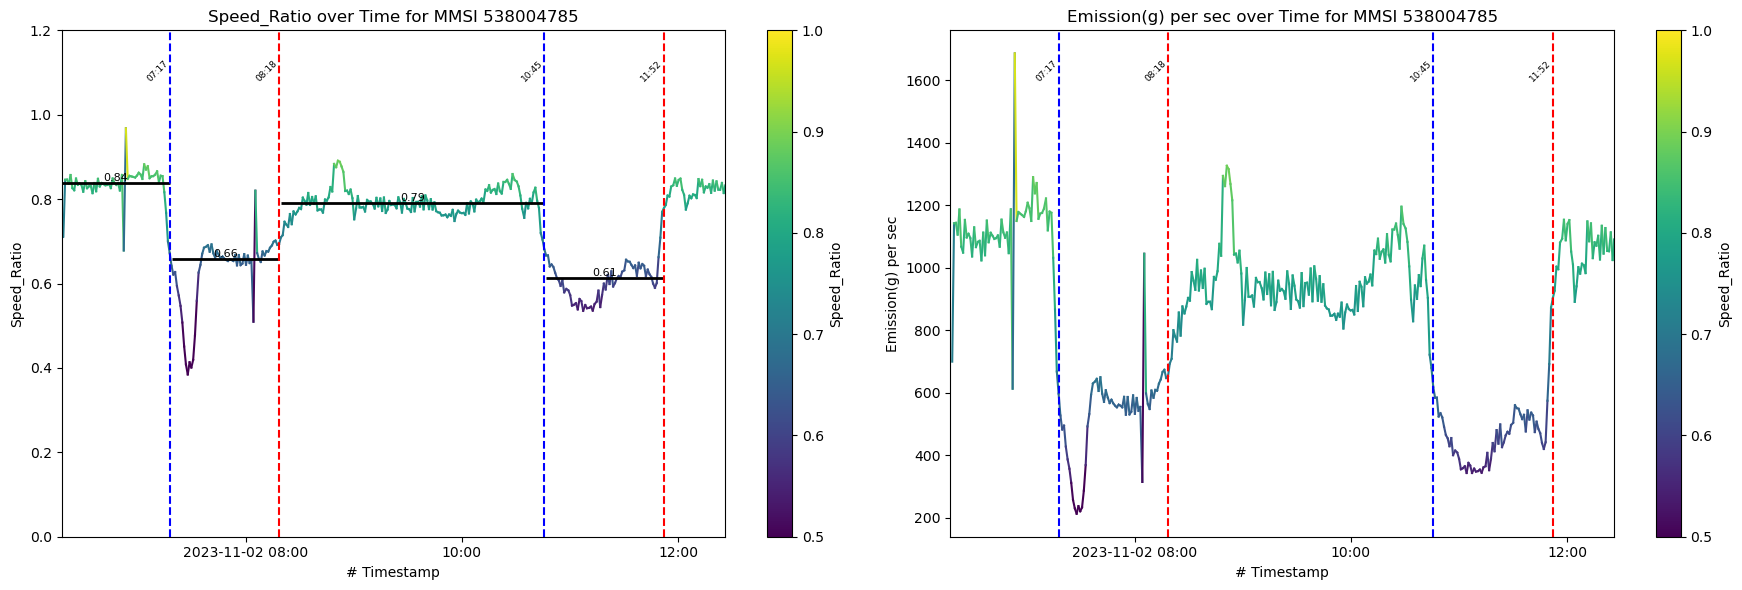

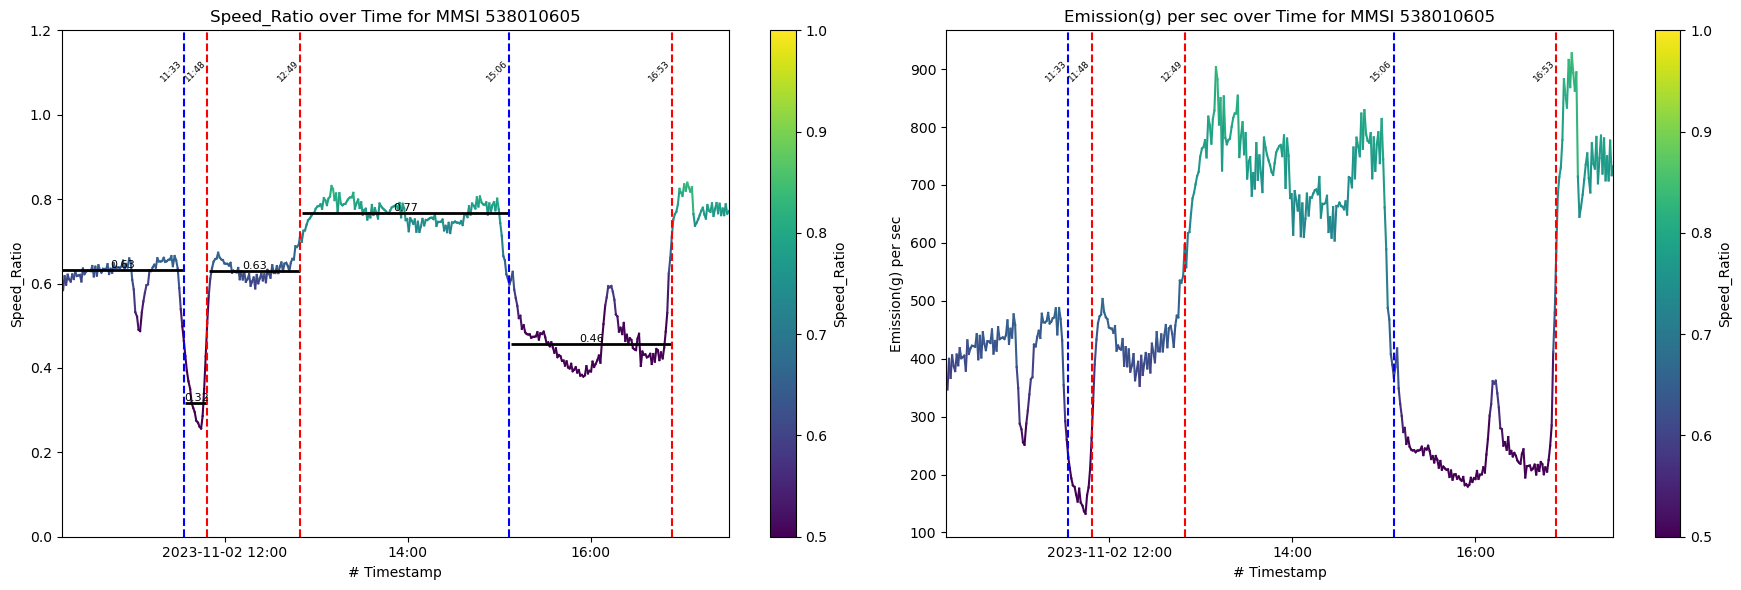

In [47]:
new_df1['# Timestamp'] = pd.to_datetime(new_df1['# Timestamp'], format='%d/%m/%Y %H:%M:%S')

grouped = new_df1.groupby('MMSI')
change_points_dict = {}

for name, group in grouped:
    test = group['Speed_Ratio'].values
    model = "l1"
    algo = rpt.Pelt(model=model).fit(test)
    # Set penalty value
    penalty_value = 1.2  
    my_bkps = algo.predict(pen=penalty_value)
    change_points_dict[name] = my_bkps[:-1] 

def custom_date_formatter(x, pos=None):
    dt = pd.to_datetime(mdates.num2date(x))
    if pos == 0:
        return dt.strftime('%Y-%m-%d %H:%M')
    else:
        return dt.strftime('%H:%M')
        
for name, group in grouped:
    plt.figure(figsize=(18, 6))
    min_time = group['# Timestamp'].min()
    max_time = group['# Timestamp'].max()

    total_hours = (max_time - min_time).total_seconds() / 3600
    if total_hours <= 1:
        hour_interval = 1 
    elif total_hours <= 6:
        hour_interval = 1  
    elif total_hours <= 12:
        hour_interval = 2  
    else:
        hour_interval = 3 

    # Speed_Ratio graph
    plt.subplot(1, 2, 1)
    timestamps = group['# Timestamp']
    speed_ratios = group['Speed_Ratio']
    cmap = plt.cm.viridis
    norm = plt.Normalize(0.5, 1)

    for i in range(len(timestamps) - 1):
        plt.plot(timestamps.iloc[i:i+2], speed_ratios.iloc[i:i+2], color=cmap(norm(speed_ratios.iloc[i])))

    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Speed_Ratio', ax=plt.gca())
    plt.title(f'Speed_Ratio over Time for MMSI {name}')
    plt.xlabel('# Timestamp')
    plt.ylabel('Speed_Ratio')
    plt.ylim(0, 1.2)
    plt.xlim(min_time, max_time)
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=hour_interval))
    plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(custom_date_formatter))
    plt.xticks(rotation=0)

    # Display change points and median values (Speed_Ratio)
    change_points = [0] + change_points_dict[name] + [len(group)]
    for i in range(1, len(change_points) - 1):
        prev_cp = change_points[i - 1]
        cp = change_points[i]
        next_cp = change_points[i + 1]
        cp_date = group['# Timestamp'].iloc[cp - 1]

        # Calculate previous and next median values
        before_median = group['Speed_Ratio'].iloc[prev_cp:cp].median()
        after_median = group['Speed_Ratio'].iloc[cp:next_cp].median()
        delta = after_median - before_median

        if delta > 0.05:
            color = 'red'  
        elif delta > 0:
            color = 'lightcoral'  
        elif delta < -0.05:
            color = 'blue' 
        elif delta < 0:
            color = 'lightblue'  
        else:
            color = 'grey'  

        # Draw median line
        median_value = before_median
        median_time_start = group['# Timestamp'].iloc[prev_cp]
        median_time_end = group['# Timestamp'].iloc[cp - 1]
        plt.hlines(median_value, median_time_start, median_time_end, colors='black', linestyles='-', linewidth=2)

        # Display median values
        plt.text(median_time_start + (median_time_end - median_time_start) / 2, median_value,
                 f'{median_value:.2f}',
                 color='black', fontsize=8, ha='center', va='bottom')

        # Display change points
        plt.axvline(x=cp_date, color=color, linestyle='--')
        plt.text(cp_date,
                 plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.9,
                 cp_date.strftime('%H:%M'),
                 rotation=45, color='black', fontsize=6.5, ha='right')

    # Emission per sec graph
    plt.subplot(1, 2, 2)
    emissions = group['Emission per sec']

    for i in range(len(timestamps) - 1):
        plt.plot(timestamps.iloc[i:i+2], emissions.iloc[i:i+2], color=cmap(norm(speed_ratios.iloc[i])))

    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Speed_Ratio', ax=plt.gca())
    plt.title(f'Emission(g) per sec over Time for MMSI {name}')
    plt.xlabel('# Timestamp')
    plt.ylabel('Emission(g) per sec')
    plt.xlim(min_time, max_time)
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=hour_interval))
    plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(custom_date_formatter))
    plt.xticks(rotation=0)

    for i in range(1, len(change_points) - 1):
        prev_cp = change_points[i - 1]
        cp = change_points[i]
        next_cp = change_points[i + 1]
        cp_date = group['# Timestamp'].iloc[cp - 1]

        before_median = group['Speed_Ratio'].iloc[prev_cp:cp].median()
        after_median = group['Speed_Ratio'].iloc[cp:next_cp].median()
        delta = after_median - before_median

        if delta > 0.05:
            color = 'red'  
        elif delta > 0:
            color = 'lightcoral' 
        elif delta < -0.05:
            color = 'blue'  
        elif delta < 0:
            color = 'lightblue' 
        else:
            color = 'grey' 

        segment = group['Emission per sec'].iloc[prev_cp:cp]
        median_value = segment.median()
        median_time_start = group['# Timestamp'].iloc[prev_cp]
        median_time_end = group['# Timestamp'].iloc[cp - 1]

        plt.axvline(x=cp_date, color=color, linestyle='--')
        plt.text(cp_date,
                 plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.9,
                 cp_date.strftime('%H:%M'),
                 rotation=45, color='black', fontsize=6.5, ha='right')

    plt.tight_layout()
    plt.show()

## Change Point Mapping

In [48]:
new_df1['# Timestamp'] = pd.to_datetime(new_df1['# Timestamp'], format='%d/%m/%Y %H:%M:%S')

grouped = new_df1.groupby('MMSI')
change_points_dict = {}

for name, group in grouped:
    test = group['Speed_Ratio'].values
    model = "l1"
    algo = rpt.Pelt(model=model).fit(test)
    # Set penalty value
    penalty_value =1.2  # This value may need to be adjusted based on the data.
    my_bkps = algo.predict(pen=penalty_value)
    change_points_dict[name] = my_bkps[:-1]  # Exclude the last element

kwargs = {**hvplot_defaults, 'line_width':4}
threshold = 0.05  # Set the desired threshold

def get_color_change(prev_values, next_values):
    """Function to calculate the direction of change and speed difference"""
    prev_median = np.median(prev_values)
    next_median = np.median(next_values)
    speed_diff = next_median - prev_median

    color = 'red' if speed_diff > 0 else 'blue'
    return color, speed_diff

change_points_data = []
colors = []
speed_diffs = []

for name, group in grouped:
    cp_indices = [0] + change_points_dict[name] + [len(group)]
    for i in range(1, len(cp_indices) - 1):
        prev_values = group['Speed_Ratio'].iloc[cp_indices[i - 1]:cp_indices[i]]
        next_values = group['Speed_Ratio'].iloc[cp_indices[i]:cp_indices[i + 1]]

        color, speed_diff = get_color_change(prev_values, next_values)

        # Apply threshold to remove small changes
        if abs(speed_diff) >= threshold:
            colors.append(color)
            speed_diffs.append(speed_diff)
            change_points_data.append(group.iloc[cp_indices[i] - 1])
        else:
            # Skip change points with variations below the threshold
            continue

# Calculate absolute values of speed differences
abs_speed_diffs = np.abs(speed_diffs)
abs_speed_diffs = np.clip(abs_speed_diffs, None, 0.8) # Set an upper limit

# Apply an exponential scale to determine circle size
size_factor = 50  # Scaling factor for visualization
min_size = 0   # Set minimum circle size

# Apply exponential function and add minimum size
sizes = (np.exp(abs_speed_diffs*6)) * 10 + min_size

# Create GeoDataFrame
change_points_df = pd.DataFrame(change_points_data)
geometry = [Point(xy) for xy in zip(change_points_df['Longitude'], change_points_df['Latitude'])]
change_points_df = gpd.GeoDataFrame(change_points_df, geometry=geometry, crs='EPSG:4326')

# Add color and size information
change_points_df['color'] = colors
change_points_df['size'] = sizes

# Set transparency
alpha_value = 0.35   # Value between 0 (transparent) and 1 (opaque)

# Visualization
change_points_df.hvplot(geo=True, c='color', size='size', alpha=alpha_value, **kwargs)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (color,size)

## Extract Key Change Points Using DBSCAN

In [54]:
# Extract coordinates from the 'geometry' column
coordinates = change_points_df['geometry'].apply(lambda geom: (geom.x, geom.y))

# Create and fit the DBSCAN model
dbscan_model = DBSCAN(eps=0.1, min_samples=2)
clusters = dbscan_model.fit_predict(list(coordinates))

change_points_df['cluster'] = clusters

# Extract outliers and points belonging to clusters
outliers = change_points_df[change_points_df['cluster'] == -1]
clustered_points = change_points_df[change_points_df['cluster'] != -1]
clustered_points.hvplot(geo=True, c='color', size='size',alpha=alpha_value,**kwargs)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (color,size)

## Visualize Change Points Detected by DBSCAN Along with the Trajectory

In [71]:
for trajectory in smoothed.trajectories:
    current_mmsi = trajectory.df['MMSI'].iloc[0]

    # Plot only when MMSI is 538004785
    if current_mmsi == 538004785:
        filtered_points = clustered_points[clustered_points['MMSI'] == current_mmsi]
        title_with_mmsi = f'Speed_Ratio - MMSI: {current_mmsi}'
        plot_trajectory = trajectory.hvplot(c='Speed_Ratio', title=title_with_mmsi, clim=(0.5, 1), **kwargs)

        # Generate points_plot only if filtered_points is not empty
        if not filtered_points.empty:
            points_plot = filtered_points.hvplot(geo=True, c='color', size='size', alpha=0.3, **kwargs)
            plot = plot_trajectory * points_plot
        else:
            plot = plot_trajectory  # If filtered_points is empty, use only plot_trajectory

        display(plot)

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Path.I    :Path   [Longitude,Latitude]   (Speed_Ratio)
   .Points.I  :Points   [Longitude,Latitude]   (Speed_Ratio,triangle_angle)
   .WMTS.II   :WMTS   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]   (color,size)